# Phân lớp

## Import thư viện

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from PIL import Image
import os
import numpy as np 
from sklearn.metrics import confusion_matrix, classification_report 
import seaborn as sns 
import matplotlib.pyplot as plt 

## Xây dựng Dataset và DataLoader

In [2]:
class ChessPiecesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.samples = []
        for target_class in self.classes:
            class_dir = os.path.join(self.root_dir, target_class)
            for root, _, fnames in sorted(os.walk(class_dir, followlinks=True)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    item = path, self.class_to_idx[target_class]
                    self.samples.append(item)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        sample = Image.open(path).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target

In [3]:
# Data augmentation và transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
# Create datasets
train_dataset = ChessPiecesDataset(root_dir='/kaggle/input/chesspieces/ChessPieces_Dataset/train', transform=train_transforms)
val_dataset = ChessPiecesDataset(root_dir='/kaggle/input/chesspieces/ChessPieces_Dataset/val', transform=val_test_transforms)
test_dataset = ChessPiecesDataset(root_dir='/kaggle/input/chesspieces/ChessPieces_Dataset/test', transform=val_test_transforms)


# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Chọn và xây dựng mô hình Resnet50

In [5]:
# Sử dụng pre-trained ResNet
model = models.resnet50(weights=True)

# Thay đổi lớp fully connected cuối cùng
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)  # 6 lớp quân cờ

# Chuyển mô hình sang GPU 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 210MB/s]


cuda:0


## Huấn luyện mô hình

In [6]:
# Định nghĩa hàm mất mát và optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  

# Huấn luyện
num_epochs = 30  
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  
        optimizer.step()  

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_dataset)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

  
    model.eval()  
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad(): 
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_loss = running_loss / len(val_dataset)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)


    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

Epoch 1/30, Train Loss: 0.6877, Train Acc: 74.40%, Val Loss: 0.5551, Val Acc: 80.28%
Epoch 2/30, Train Loss: 0.4191, Train Acc: 84.78%, Val Loss: 0.3392, Val Acc: 87.36%
Epoch 3/30, Train Loss: 0.2833, Train Acc: 89.68%, Val Loss: 0.2858, Val Acc: 90.14%
Epoch 4/30, Train Loss: 0.2411, Train Acc: 91.50%, Val Loss: 0.2963, Val Acc: 92.08%
Epoch 5/30, Train Loss: 0.1893, Train Acc: 93.58%, Val Loss: 0.2917, Val Acc: 91.94%
Epoch 6/30, Train Loss: 0.1675, Train Acc: 94.15%, Val Loss: 0.2701, Val Acc: 90.97%
Epoch 7/30, Train Loss: 0.1326, Train Acc: 95.48%, Val Loss: 0.2252, Val Acc: 94.03%
Epoch 8/30, Train Loss: 0.1297, Train Acc: 95.55%, Val Loss: 0.2758, Val Acc: 93.06%
Epoch 9/30, Train Loss: 0.1093, Train Acc: 96.36%, Val Loss: 0.2509, Val Acc: 92.50%
Epoch 10/30, Train Loss: 0.1015, Train Acc: 96.69%, Val Loss: 0.3014, Val Acc: 93.19%
Epoch 11/30, Train Loss: 0.0897, Train Acc: 97.13%, Val Loss: 0.4040, Val Acc: 90.42%
Epoch 12/30, Train Loss: 0.1092, Train Acc: 96.47%, Val Loss: 0

## Đánh giá mô hình trên tập test

In [7]:
model.eval()  
correct = 0
total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predictions.extend(predicted.cpu().numpy())  
        all_labels.extend(labels.cpu().numpy()) 


print(f'Accuracy on the test set: {100 * correct / total:.2f}%')

Accuracy on the test set: 94.72%


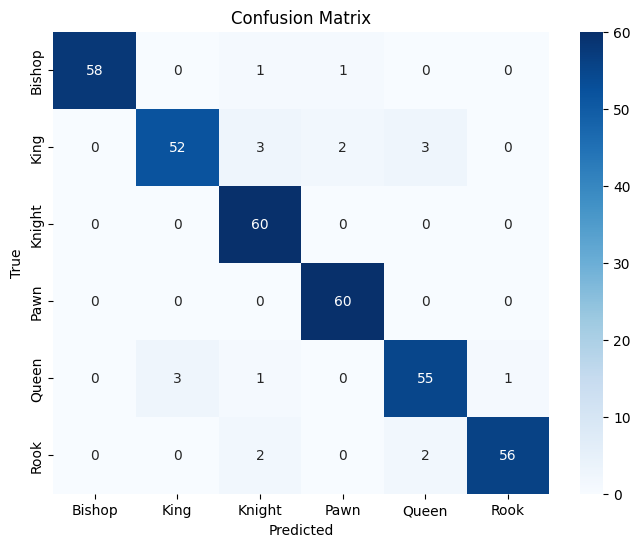

In [8]:
# Confusion matrix 
cm = confusion_matrix(all_labels, all_predictions)
class_names = test_dataset.classes 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [9]:
# Classification report
print(classification_report(all_labels, all_predictions, target_names=class_names))

              precision    recall  f1-score   support

      Bishop       1.00      0.97      0.98        60
        King       0.95      0.87      0.90        60
      Knight       0.90      1.00      0.94        60
        Pawn       0.95      1.00      0.98        60
       Queen       0.92      0.92      0.92        60
        Rook       0.98      0.93      0.96        60

    accuracy                           0.95       360
   macro avg       0.95      0.95      0.95       360
weighted avg       0.95      0.95      0.95       360



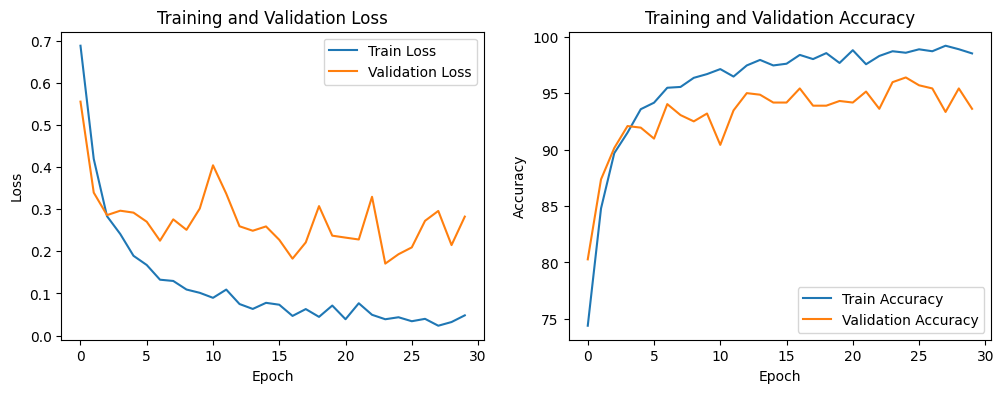

In [10]:
# Vẽ loss và accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

## Lưu mô hình

In [12]:
torch.save(model.state_dict(), '/kaggle/working/chess_classifier_resnet.pth')